# Logistic Regression experiments (notebook)

This notebook runs Logistic Regression experiments with multiple embedding types (TF-IDF, Word2Vec skip-gram, Word2Vec CBOW).
It reuses the preprocessing approach from `data_preprocessing.ipynb` and references other team notebooks so you can see how others organized RNN experiments.

Files to reference in this repo:
- `scripts/data_preprocessing.ipynb` — original cleaning and EDA (clean_text, stopword removal).
- `scripts/text-classification-rnn.ipynb` — example RNN experiments using TF-IDF and Word2Vec (skipgram/cbow).
- `scripts/embeddings.py` — helper functions to train Word2Vec and build document vectors (used by the script runner).
- `scripts/logistic_regression.py` — a CLI runner that runs the same experiments (useful for batch runs / reproducibility).

Use the cells below to run experiments interactively. Update the `data_path` variable to point to your CSV file.

In [10]:
# Basic imports
import os
import sys
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Make plots inline (if running in Jupyter)
%matplotlib inline

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Add repo root to sys.path so we can import local helper scripts if available
repo_root = Path('..').resolve()
sys.path.append(str(repo_root))
# Also ensure the `scripts/` directory is on sys.path so we can import `embeddings.py` as a top-level module
scripts_path = repo_root / 'scripts'
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

# Try to import helper embeddings from `scripts/embeddings.py`
try:
    # If this notebook is executed from `scripts/` the module will be available as `embeddings`
    import embeddings as local_embeddings
    train_word2vec = local_embeddings.train_word2vec
    build_doc_vectors_w2v = local_embeddings.build_doc_vectors_w2v
    print('Imported embeddings from local `scripts/embeddings.py`.')
except Exception as e:
    # Fallback: define minimal local implementations so the notebook can run standalone.
    print('Could not import local embeddings.py, using inline fallback. Error:', e)
    from gensim.models import Word2Vec
    def train_word2vec(sentences, vector_size=100, window=5, min_count=2, sg=1, epochs=10):
        model = Word2Vec(vector_size=vector_size, window=window, min_count=min_count, sg=sg, workers=4)
        model.build_vocab(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=epochs)
        return model

    def doc_vector(model, tokens):
        vecs = [model.wv[t] for t in tokens if t in model.wv]
        if not vecs:
            return np.zeros(model.vector_size, dtype=np.float32)
        return np.mean(vecs, axis=0)

    def build_doc_vectors_w2v(model, tokenized_texts):
        return np.vstack([doc_vector(model, t) for t in tokenized_texts])

Imported embeddings from local `scripts/embeddings.py`.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blueclover/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Data path: update this to your CSV file path before running
data_path ='../data/alldata_1_for_kaggle.csv'
text_col = 'Research_Text'
label_col = 'Target_Labels'

assert os.path.exists(data_path), f'Please set data_path to a valid file (currently: {data_path})'

df = pd.read_csv(data_path, encoding='latin-1')
print('Loaded:', df.shape)
display(df.head())

Loaded: (7570, 3)


,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [12]:
# Inspect and auto-detect text and label columns (run after df = pd.read_csv(...))
print('Raw columns:', df.columns.tolist())

# Strip whitespace and normalize column names for safety
df.columns = df.columns.str.strip()
print('Stripped columns:', df.columns.tolist())
display(df.head(3))

text_candidates = ['research_text', 'research text', 'text', 'abstract', 'a', 'body', 'content', 'paper', 'article']
label_candidates = ['target_labels', 'target label', 'target', 'label', 'class', 'y', '0', 'category']

def find_col(df, candidates):
    # Exact match (case-insensitive) first
    cols_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_map:
            return cols_map[cand.lower()]
    # Then try partial match (column contains candidate substring)
    for cand in candidates:
        for col in df.columns:
            if cand.lower() in col.lower():
                return col
    return None

detected_text_col = find_col(df, text_candidates)
detected_label_col = find_col(df, label_candidates)

if detected_text_col:
    print('Detected text column:', detected_text_col)
    text_col = detected_text_col
else:
    print('No text column auto-detected. Please set `text_col` manually from:')
    print(df.columns.tolist())

if detected_label_col:
    print('Detected label column:', detected_label_col)
    label_col = detected_label_col
else:
    print('No label column auto-detected. Please set `label_col` manually from:')
    print(df.columns.tolist())

# Safe preprocessing: only run if text_col exists in the dataframe
if 'text_col' not in locals():
    print(
)
elif text_col not in df.columns:
    print(f"Detected text_col='{text_col}' not found in dataframe columns. Available columns: {df.columns.tolist()}")
else:
    # Cleaning functions (keeps hyphens and apostrophes, preserves numbers)
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'<.*?>', ' ', text)
        text = re.sub(r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", '', text)
        text = re.sub(r'\[\d+(?:,\s*\d+)*\]', ' [CITATION] ', text)
        text = re.sub(r'/', ' ', text)
        # Remove punctuation except hyphens and apostrophes
        text = re.sub(r"[^\w\s\-']", ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def remove_stopwords(text):
        words = text.split()
        filtered_words = [w for w in words if w.lower() not in stop_words]
        return ' '.join(filtered_words)

    # Apply preprocessing (may be slow for very large datasets)
    df[text_col] = df[text_col].astype(str).apply(clean_text).apply(remove_stopwords)
    df['Text_Length'] = df[text_col].apply(lambda x: len(x.split()))
    print('After cleaning:', df.shape)
    display(df.head())

Raw columns: ['Unnamed: 0', '0', 'a']
Stripped columns: ['Unnamed: 0', '0', 'a']


,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...


Detected text column: a
Detected label column: 0
After cleaning: (7570, 4)


,Unnamed: 0,0,a,Text_Length
0,0,Thyroid_Cancer,thyroid surgery children single institution os...,2016
1,1,Thyroid_Cancer,adopted strategy used prior years based four e...,1673
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï br...,2241
3,3,Thyroid_Cancer,solitary plasmacytoma sp skull uncommon clinic...,1320
4,4,Thyroid_Cancer,study aimed investigate serum matrix metallopr...,2192


/var/folders/2g/q9w5k8lj2792_wvx696tm3mr0000gn/T/ipykernel_29572/3633267148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, palette='viridis')


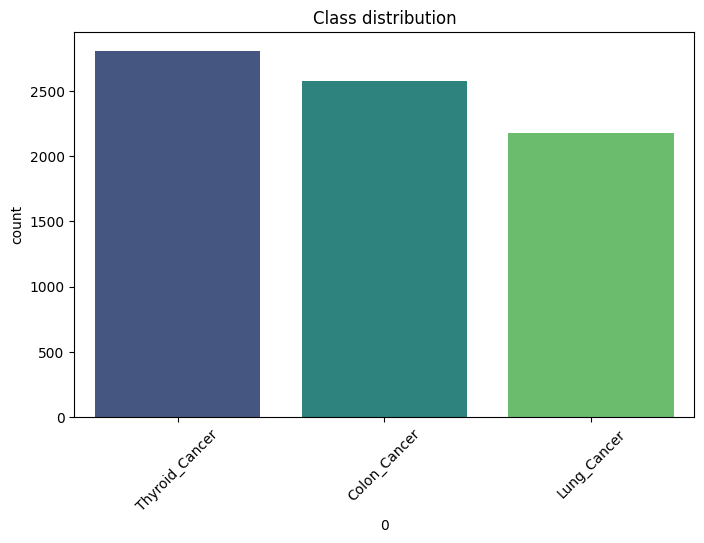

In [13]:
# Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, palette='viridis')
plt.title('Class distribution')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Train/validation/test split (three-way) and label encoding
X = df[text_col].tolist()
y = df[label_col].tolist()

# Create a test set of 15% then split the remaining into train/val (approx 70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp)
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Train: 5301, Val: 1133, Test: 1136


In [15]:
# Embedding controls: keep embedding vocabularies bounded to avoid large memory use
TFIDF_MAX_FEATURES = 20000  # controls TF-IDF feature dimensionality
W2V_MAX_VOCAB = 10000  # top-K tokens to train/load for Word2Vec
MAX_GLOVE_VOCAB = 10000  # top-K tokens to load from GloVe

# Tokenize train/val texts (simple whitespace) and build frequency counts
tokenized_train = [t.split() for t in X_train]
tokenized_val = [t.split() for t in X_val]
from collections import Counter as _Counter
train_word_counts = _Counter()
for t in tokenized_train:
    train_word_counts.update(t)

# Target vocabs for embeddings (top-K most frequent words)
target_w2v_vocab = set([w for w, _ in train_word_counts.most_common(W2V_MAX_VOCAB)])
target_glove_vocab = set([w for w, _ in train_word_counts.most_common(MAX_GLOVE_VOCAB)])
print(f'Prepared target vocab sizes -> W2V: {len(target_w2v_vocab)}, GloVe target: {len(target_glove_vocab)}')

# Filter token lists to top-K for training Word2Vec and for GloVe lookup
tokenized_train_filtered = [[w for w in doc if w in target_w2v_vocab] for doc in tokenized_train]
tokenized_val_filtered = [[w for w in doc if w in target_w2v_vocab] for doc in tokenized_val]


Prepared target vocab sizes -> W2V: 10000, GloVe target: 10000


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/bluecl

Best TF-IDF C: {'C': 10.0}
                precision    recall  f1-score   support

  Colon_Cancer       0.96      0.96      0.96       386
   Lung_Cancer       1.00      1.00      1.00       326
Thyroid_Cancer       0.96      0.96      0.96       421

      accuracy                           0.97      1133
     macro avg       0.97      0.97      0.97      1133
  weighted avg       0.97      0.97      0.97      1133

Accuracy: 0.970873786407767


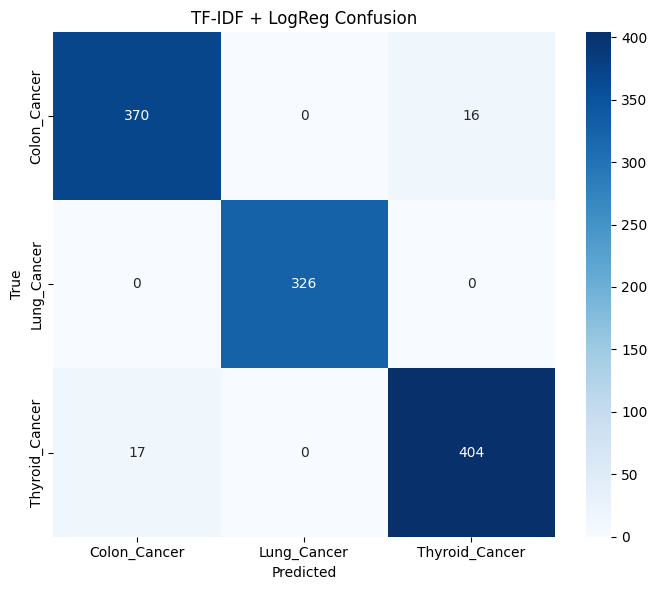

In [16]:
# TF-IDF + Logistic Regression (with a small GridSearch)
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
clf = LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial')
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(clf, param_grid, cv=cv, scoring='f1_macro', n_jobs=1, verbose=1)
gs.fit(X_train_tfidf, y_train)
print('Best TF-IDF C:', gs.best_params_)
y_pred = gs.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))
print('Accuracy:', accuracy_score(y_val, y_pred))

# Save artifacts to results folder
out_dir = Path('../results/logreg_notebook')
out_dir.mkdir(parents=True, exist_ok=True)
import joblib
joblib.dump(gs, out_dir / 'tfidf_logreg_gs.joblib')
joblib.dump(tfidf, out_dir / 'tfidf_vectorizer.joblib')

# Confusion matrix
labels_sorted = sorted(list(set(y)))
cm = confusion_matrix(y_val, y_pred, labels=labels_sorted)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='Blues')
plt.title('TF-IDF + LogReg Confusion')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(out_dir / 'tfidf_confusion.png')
plt.show()

In [17]:
# Label encoding and save preprocessed data/splits
from sklearn.preprocessing import LabelEncoder
import pickle

le = LabelEncoder()
# Fit on original y (strings) and transform to integer labels
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Replace y variables used by existing cells with encoded versions
y_train = y_train_enc
y_val = y_val_enc
y_test = y_test_enc

# Build labels_sorted for confusion matrices using encoded label integers (0..n_classes-1)
labels_sorted = list(range(len(le.classes_)))
mapping = {cls: int(i) for i, cls in enumerate(le.classes_)}
print(f'Label classes ({len(le.classes_)}):', le.classes_)
print('Label mapping (original -> encoded):', mapping)

# Save preprocessed CSV and splits for reproducibility
df.to_csv('../preprocessed_cancer_data.csv', index=False)
with open('../data_splits_logreg.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
                 'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
                 'label_encoder': le}, f)
print('Saved preprocessed data and splits.')

Label classes (3): ['Colon_Cancer' 'Lung_Cancer' 'Thyroid_Cancer']
Label mapping (original -> encoded): {np.str_('Colon_Cancer'): 0, np.str_('Lung_Cancer'): 1, np.str_('Thyroid_Cancer'): 2}
Saved preprocessed data and splits.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/bluecl

Best W2V-SG C: {'C': 1.0}
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       386
           1       1.00      1.00      1.00       326
           2       0.75      0.74      0.75       421

    accuracy                           0.81      1133
   macro avg       0.82      0.82      0.82      1133
weighted avg       0.81      0.81      0.81      1133

Accuracy: 0.8111209179170344


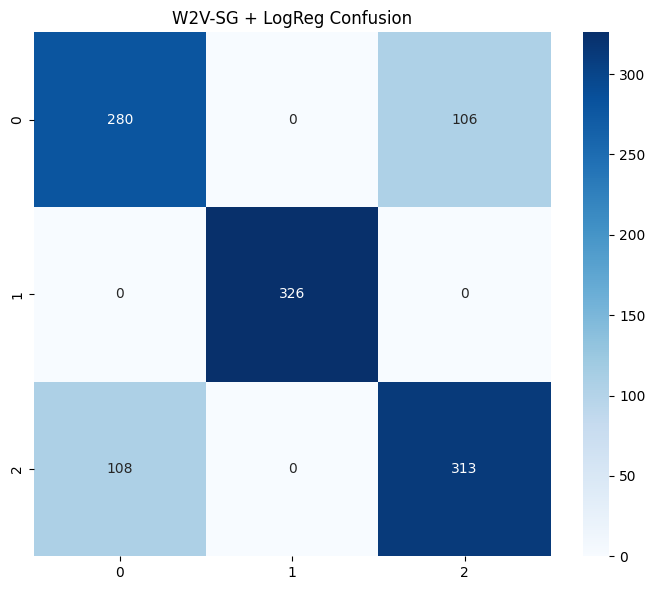

In [18]:
# Word2Vec (skip-gram) + logistic regression on averaged doc vectors
tokenized_train = [t.split() for t in X_train]
tokenized_val = [t.split() for t in X_val]

# Train Word2Vec (skip-gram) on filtered token lists to bound vocab size
w2v_sg = train_word2vec(tokenized_train_filtered, vector_size=100, window=5, min_count=2, sg=1, epochs=10)
X_train_w2v = build_doc_vectors_w2v(w2v_sg, tokenized_train_filtered)
X_val_w2v = build_doc_vectors_w2v(w2v_sg, tokenized_val_filtered)

# quick GridSearch on the dense vectors
gs_w2v = GridSearchCV(LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial'),
                     {'C': [0.01, 0.1, 1.0]}, cv=3, scoring='f1_macro', n_jobs=1, verbose=1)
gs_w2v.fit(X_train_w2v, y_train)
print('Best W2V-SG C:', gs_w2v.best_params_)
y_pred_w2v = gs_w2v.predict(X_val_w2v)
print(classification_report(y_val, y_pred_w2v))
print('Accuracy:', accuracy_score(y_val, y_pred_w2v))

joblib.dump(w2v_sg, out_dir / 'w2v_sg.model')
joblib.dump(gs_w2v, out_dir / 'w2v_sg_logreg_gs.joblib')

cm = confusion_matrix(y_val, y_pred_w2v, labels=labels_sorted)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='Blues')
plt.title('W2V-SG + LogReg Confusion')
plt.tight_layout()
plt.savefig(out_dir / 'w2v_sg_confusion.png')
plt.show()

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/blueclover/Desktop/text-classification-nlp/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/bluecl

Best W2V-CBOW C: {'C': 0.1}
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       386
           1       1.00      1.00      1.00       326
           2       0.73      0.72      0.72       421

    accuracy                           0.80      1133
   macro avg       0.81      0.81      0.81      1133
weighted avg       0.80      0.80      0.80      1133

Accuracy: 0.7961165048543689


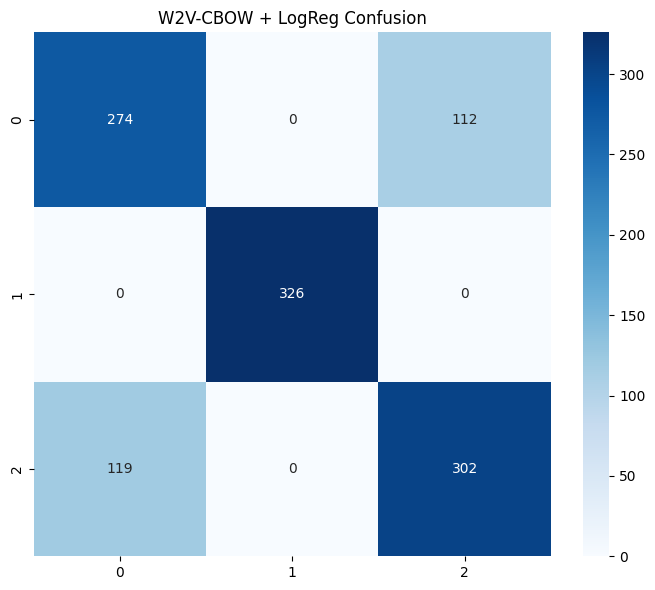

In [19]:
# Word2Vec (CBOW) + logistic regression on averaged doc vectors
# Train Word2Vec (CBOW) on filtered token lists to bound vocab size
w2v_cbow = train_word2vec(tokenized_train_filtered, vector_size=100, window=5, min_count=2, sg=0, epochs=10)
X_train_w2v_cbow = build_doc_vectors_w2v(w2v_cbow, tokenized_train_filtered)
X_val_w2v_cbow = build_doc_vectors_w2v(w2v_cbow, tokenized_val_filtered)

gs_w2v_cbow = GridSearchCV(LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial'),
                         {'C': [0.01, 0.1, 1.0]}, cv=3, scoring='f1_macro', n_jobs=1, verbose=1)
gs_w2v_cbow.fit(X_train_w2v_cbow, y_train)
print('Best W2V-CBOW C:', gs_w2v_cbow.best_params_)
y_pred_w2v_cbow = gs_w2v_cbow.predict(X_val_w2v_cbow)
print(classification_report(y_val, y_pred_w2v_cbow))
print('Accuracy:', accuracy_score(y_val, y_pred_w2v_cbow))

joblib.dump(w2v_cbow, out_dir / 'w2v_cbow.model')
joblib.dump(gs_w2v_cbow, out_dir / 'w2v_cbow_logreg_gs.joblib')

cm = confusion_matrix(y_val, y_pred_w2v_cbow, labels=labels_sorted)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='Blues')
plt.title('W2V-CBOW + LogReg Confusion')
plt.tight_layout()
plt.savefig(out_dir / 'w2v_cbow_confusion.png')
plt.show()

In [ ]:
# GloVe (bottom) — selective-load + averaged doc vectors + LogReg
from pathlib import Path
import zipfile
import requests
import json

glove_dir = Path('../embeddings')
glove_dir.mkdir(parents=True, exist_ok=True)
glove_path = glove_dir / 'glove.6B.100d.txt'

if not glove_path.exists():
    print('GloVe file not found locally. Attempting to download glove.6B.zip (if allowed)...')
    url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    zip_path = glove_dir / 'glove.6B.zip'
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(zip_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extract('glove.6B.100d.txt', path=glove_dir)
        print('Downloaded and extracted GloVe.')
    except Exception as e:
        print('Automatic download failed:', e)
        print('Please download glove.6B.100d.txt manually and place it in', glove_dir)

# Use the target_glove_vocab computed earlier if available, otherwise compute from training split
try:
    tg = target_glove_vocab
except NameError:
    from collections import Counter as _Counter
    train_word_counts = _Counter()
    tokenized_train = [t.split() for t in X_train]
    for t in tokenized_train:
        train_word_counts.update(t)
    tg = set([w for w, _ in train_word_counts.most_common(MAX_GLOVE_VOCAB)])

print(f'Will load up to {len(tg)} GloVe vectors (target vocab size: {len(tg)})')

# Load only vectors for tokens in tg to limit memory
glove_dict = {}
with open(glove_path, 'r', encoding='utf-8') as fh:
    for line in fh:
        parts = line.rstrip().split(' ')
        word = parts[0]
        if word in tg:
            vec = np.asarray(parts[1:], dtype='float32')
            glove_dict[word] = vec
        if len(glove_dict) >= len(tg):
            break

if len(glove_dict) == 0:
    raise RuntimeError('No GloVe vectors were loaded. Ensure glove file exists and encoding is correct.')

glove_dim = len(next(iter(glove_dict.values())))
print('Loaded', len(glove_dict), 'GloVe vectors (dimension', glove_dim, ')')

coverage = len(glove_dict) / float(len(tg)) if len(tg) > 0 else 0.0
print(f'Coverage of target vocab: {coverage:.2%} ({len(glove_dict)}/{len(tg)})')

# Build averaged GloVe document vectors
def glove_doc_vector(tokens):
    vecs = [glove_dict[t] for t in tokens if t in glove_dict]
    if not vecs:
        return np.zeros(glove_dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

# Tokenize (simple whitespace) and build matrices
tokenized_train = [t.split() for t in X_train]
tokenized_val = [t.split() for t in X_val]

X_train_glove = np.vstack([glove_doc_vector(t) for t in tokenized_train])
X_val_glove = np.vstack([glove_doc_vector(t) for t in tokenized_val])

# Train & evaluate logistic regression on GloVe vectors
from sklearn.model_selection import GridSearchCV

gs_glove_bottom = GridSearchCV(LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial'),
                              {'C': [0.01, 0.1, 1.0]}, cv=3, scoring='f1_macro', n_jobs=1, verbose=1)

gs_glove_bottom.fit(X_train_glove, y_train)
print('Best GloVe C:', gs_glove_bottom.best_params_)

y_pred_glove_bottom = gs_glove_bottom.predict(X_val_glove)
print(classification_report(y_val, y_pred_glove_bottom))
print('Accuracy:', accuracy_score(y_val, y_pred_glove_bottom))

# Save artifacts and coverage
out_dir = Path('../results/logreg_notebook')
out_dir.mkdir(parents=True, exist_ok=True)
import joblib
joblib.dump(gs_glove_bottom, out_dir / 'glove_logreg_gs_bottom.joblib')
with open(out_dir / 'glove_coverage_bottom.json', 'w') as jf:
    json.dump({'loaded': len(glove_dict), 'target_vocab': len(tg), 'coverage': coverage}, jf)

# Confusion matrix (use encoded labels_sorted defined earlier)
cm = confusion_matrix(y_val, y_pred_glove_bottom, labels=labels_sorted)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='Blues')
plt.title('GloVe + LogReg Confusion (bottom cell)')
plt.tight_layout()
plt.savefig(out_dir / 'glove_confusion_bottom.png')
plt.show()


GloVe file not found locally. Attempting to download glove.6B.zip (if allowed)...
